# Image Processing Challenge - OPTIMIZED FOR A100

## All Imports

In [1]:
import pickle, numpy as np
import matplotlib.pyplot as plt
import pickle, numpy as np, os, csv
from collections import defaultdict
import pickle, numpy as np, torch
from torch.utils.data import Dataset
import torch, torch.nn as nn
import time


## Adding Morpho Filters

In [2]:
import cv2
import numpy as np
import torch

def morphological_smooth_mask(mask, kernel_size=3, operation='close'):
    """
    Apply morphological operations to smooth binary/segmentation masks.

    Args:
        mask: numpy array or torch tensor (H, W) or (B, H, W) or (B, C, H, W)
        kernel_size: size of the morphological kernel
        operation: 'close', 'open', or 'both'
    """
    # Convert to numpy if needed
    is_tensor = isinstance(mask, torch.Tensor)
    if is_tensor:
        device = mask.device
        mask_np = mask.cpu().numpy()
    else:
        mask_np = mask.copy()

    # Create kernel (circular is good default)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Handle different dimensions
    original_shape = mask_np.shape
    if len(original_shape) == 2:  # Single mask (H, W)
        masks_to_process = [mask_np]
    elif len(original_shape) == 3:  # Batch (B, H, W)
        masks_to_process = list(mask_np)
    elif len(original_shape) == 4:  # Batch with channels (B, C, H, W)
        # Process each channel separately
        B, C, H, W = original_shape
        masks_to_process = [mask_np[b, c] for b in range(B) for c in range(C)]

    # Process each mask
    processed_masks = []
    for m in masks_to_process:
        # Ensure binary format for morphology
        m_binary = (m > 0.5).astype(np.uint8)

        if operation == 'close':
            # Closing: fills gaps
            m_processed = cv2.morphologyEx(m_binary, cv2.MORPH_CLOSE, kernel)
        elif operation == 'open':
            # Opening: removes small noise
            m_processed = cv2.morphologyEx(m_binary, cv2.MORPH_OPEN, kernel)
        elif operation == 'both':
            # Opening then closing
            m_processed = cv2.morphologyEx(m_binary, cv2.MORPH_OPEN, kernel)
            m_processed = cv2.morphologyEx(m_processed, cv2.MORPH_CLOSE, kernel)
        elif operation == 'dilate':
            # Just dilation - makes features bigger
            m_processed = cv2.dilate(m_binary, kernel)

        processed_masks.append(m_processed.astype(np.float32))

    # Reshape back
    if len(original_shape) == 2:
        result = processed_masks[0]
    elif len(original_shape) == 3:
        result = np.stack(processed_masks)
    elif len(original_shape) == 4:
        result = np.array(processed_masks).reshape(original_shape)

    # Convert back to tensor if needed
    if is_tensor:
        result = torch.from_numpy(result).to(device)

    return result

# Optional: Augmentation class for use in transforms
class MorphologicalSmoothing:
    def __init__(self, kernel_size=3, operation='close', probability=0.5):
        self.kernel_size = kernel_size
        self.operation = operation
        self.probability = probability

    def __call__(self, mask):
        if np.random.random() < self.probability:
            return morphological_smooth_mask(mask, self.kernel_size, self.operation)
        return mask

## Quick Data Inspection

In [3]:
from google.colab import drive
drive.mount('/content/drive')

#d = pickle.load(open("labeled_training_set.pkl","rb"))
# Specify the full path to the .pkl file
pkl_path = "/content/drive/MyDrive/Hackathon_Challenge2/labeled_training_set.pkl"

d = pickle.load(open(pkl_path, "rb"))

# one sample (fused lighting: 9 channels)
item = d['part01'][0]
imgs = np.stack([item['images']['A'+item['layer_id']+k] for k in ['a','b','c']], axis=0)  # (3,139,250,3)
x = np.transpose(imgs, (1,2,0,3)).reshape(139,250,9)  # H,W,9
y = np.stack([item['spot_label'], item['streak_label']], axis=0)  # (2,139,250)

print(f"Input shape: {x.shape}, Labels shape: {y.shape}")
print(f"Spot pixels: {np.mean(y[0]):.4f}, Streak pixels: {np.mean(y[1]):.4f}")


Mounted at /content/drive
Input shape: (139, 250, 9), Labels shape: (2, 139, 250)
Spot pixels: 0.0070, Streak pixels: 0.1277


## Preparing the Dataset

In [4]:
%%writefile dataset_nist.py
import pickle, numpy as np, torch
from torch.utils.data import Dataset
import albumentations as A
import cv2  # Need this for morphological_smooth_mask

def _pad_to_hw_torch(x, Ht, Wt, value=0.0):
    # x: torch tensor (C,H,W)
    import torch.nn.functional as F
    C,H,W = x.shape
    ph = max(0, Ht - H); pw = max(0, Wt - W)
    tp = ph//2; bp = ph - tp
    lp = pw//2; rp = pw - lp
    return F.pad(x, (lp, rp, tp, bp), value=value)

def morphological_smooth_mask(mask, kernel_size=3, operation='close'):
    """
    Apply morphological operations to smooth binary/segmentation masks.
    Note: Simplified version - adjust based on your needs
    """
    # Handle numpy arrays
    if isinstance(mask, np.ndarray):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        mask_binary = (mask > 0.5).astype(np.uint8)

        if operation == 'close':
            result = cv2.morphologyEx(mask_binary, cv2.MORPH_CLOSE, kernel)
        elif operation == 'open':
            result = cv2.morphologyEx(mask_binary, cv2.MORPH_OPEN, kernel)
        elif operation == 'dilate':
            result = cv2.dilate(mask_binary, kernel)
        elif operation == 'erode':
            result = cv2.erode(mask_binary, kernel)
        else:
            result = mask_binary

        return result.astype(np.float32)
    else:
        # For torch tensors, convert to numpy, process, convert back
        device = mask.device
        mask_np = mask.cpu().numpy()
        processed = morphological_smooth_mask(mask_np, kernel_size, operation)
        return torch.from_numpy(processed).to(device)

class NISTSegDataset(Dataset):
    """Stacks a/b/c RGB -> 9-ch, pads to 144x256 (divisible by 16), keeps a/b/c of same layer together."""
    def __init__(self, pkl_path, split="train", val_frac=0.2, seed=42, target_hw=(144,256), augment=False, apply_morphology=True):
        d = pickle.load(open(pkl_path, "rb"))
        items = []
        for part in sorted(d.keys()):
            items.extend(d[part])  # each is a layer dict

        # group by layer_id so a/b/c stay together
        from collections import defaultdict
        g = defaultdict(list)
        for it in items: g[it["layer_id"]].append(it)

        ids = list(g.keys())
        rng = np.random.default_rng(seed); rng.shuffle(ids)
        n_val = int(len(ids)*val_frac)
        val_ids = set(ids[:n_val])

        keep = (lambda lid: lid in val_ids) if split=="val" else (lambda lid: lid not in val_ids)
        self.layers = [it for lid in ids if keep(lid) for it in g[lid]]
        self.target_hw = target_hw
        self.augment = augment
        self.apply_morphology = apply_morphology

        # Define augmentation pipeline with PROPER additional_targets
        if self.augment:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate(limit=15, p=0.7),
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
                A.GaussNoise(var_limit=(5.0, 15.0), p=0.3),
            ], additional_targets={
                'image2': 'image',   # img_b follows same transform as img_a
                'image3': 'image',   # img_c follows same transform as img_a
                'mask2': 'mask'      # streak_mask follows same transform as spot_mask
            })

    def __len__(self):
        return len(self.layers)

    def __getitem__(self, idx):
        lyr = self.layers[idx]
        lid = lyr["layer_id"]
        im = lyr["images"]

        # Get the three lighting conditions as separate images
        img_a = im[f"A{lid}a"]  # (139, 250, 3)
        img_b = im[f"A{lid}b"]
        img_c = im[f"A{lid}c"]

        # Get masks
        spot_mask = lyr["spot_label"].astype(np.float32)
        streak_mask = lyr["streak_label"].astype(np.float32)

        # Apply morphology BEFORE augmentation
        if self.apply_morphology:
            spot_mask = morphological_smooth_mask(
                spot_mask, kernel_size=3, operation='dilate'
            )
            streak_mask = morphological_smooth_mask(
                streak_mask, kernel_size=3, operation='close'
            )

        # Apply augmentations if in training mode
        if self.augment:
            # This applies THE SAME transform to all images and masks
            augmented = self.transform(
                image=img_a,
                image2=img_b,
                image3=img_c,
                mask=spot_mask,
                mask2=streak_mask
            )
            img_a = augmented['image']
            img_b = augmented['image2']  # Same geometric transform as img_a
            img_c = augmented['image3']  # Same geometric transform as img_a
            spot_mask = augmented['mask']
            streak_mask = augmented['mask2']

        # Stack lighting a/b/c → 9 channels
        x = np.concatenate([img_a, img_b, img_c], axis=2).astype(np.float32)/255.0
        x = torch.from_numpy(np.transpose(x, (2,0,1)))  # (9,H,W)

        # Stack masks
        y = torch.from_numpy(np.stack([spot_mask, streak_mask], axis=0))  # (2,H,W)

        # Pad to target size
        Ht,Wt = self.target_hw
        x = _pad_to_hw_torch(x, Ht, Wt, value=0.0)
        y = _pad_to_hw_torch(y, Ht, Wt, value=0.0)

        return x, y

Writing dataset_nist.py


## Enhanced U-Net Architecture (base=48)

In [5]:
%%writefile model_unet_tiny.py
import torch, torch.nn as nn

def conv_block(cin, cout, dropout=0.0):
    layers = [
        nn.Conv2d(cin, cout, 3, padding=1),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True),
        nn.Conv2d(cout, cout, 3, padding=1),
        nn.BatchNorm2d(cout),
        nn.ReLU(inplace=True)
    ]
    if dropout > 0:
        layers.append(nn.Dropout2d(dropout))
    return nn.Sequential(*layers)

class UNetTiny(nn.Module):
    def __init__(self, in_ch=9, out_ch=2, base=48, dropout=0.1):
        super().__init__()
        self.enc1 = conv_block(in_ch, base)
        self.enc2 = conv_block(base, base*2, dropout)
        self.enc3 = conv_block(base*2, base*4, dropout)
        self.pool = nn.MaxPool2d(2)
        self.bott = conv_block(base*4, base*8, dropout)
        self.up3  = nn.ConvTranspose2d(base*8, base*4, 2, 2)
        self.dec3 = conv_block(base*8, base*4, dropout)
        self.up2  = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.dec2 = conv_block(base*4, base*2, dropout)
        self.up1  = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.dec1 = conv_block(base*2, base)
        self.head = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b  = self.bott(self.pool(e3))
        d3 = self.up3(b); d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3); d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2); d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return self.head(d1)  # logits

class WeightedBCEDiceLoss(nn.Module):
    def __init__(self, spot_weight=500.0, streak_weight=1.0, smooth=1.0, bce_weight=0.5):
        """
        Weighted loss for severe class imbalance.
        Spots are 0.21% of pixels -> weight ~500
        Streaks are 13.7% of pixels -> weight ~1
        """
        super().__init__()
        self.smooth = smooth
        self.bce_weight = bce_weight
        # Create weight tensor for 2 channels [spots, streaks]
        self.class_weights = torch.tensor([spot_weight, streak_weight])

    def forward(self, logits, targets):
        # Move weights to same device as logits
        weights = self.class_weights.to(logits.device).view(1, 2, 1, 1)

        # Weighted BCE
        bce = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, reduction='none'
        )
        weighted_bce = (bce * weights).mean()

        # Dice loss (already handles imbalance well)
        probs = torch.sigmoid(logits)
        dims = (0,2,3)
        inter = (probs*targets).sum(dims)
        denom = probs.sum(dims) + targets.sum(dims)
        dice = (2*inter + self.smooth) / (denom + self.smooth)
        dice_loss = 1 - dice.mean()

        return self.bce_weight * weighted_bce + (1-self.bce_weight) * dice_loss


Writing model_unet_tiny.py


## Loading models without restarting notebook

In [6]:
# (re)load newly written modules
import importlib, dataset_nist, model_unet_tiny
importlib.reload(dataset_nist)
importlib.reload(model_unet_tiny)


<module 'model_unet_tiny' from '/content/model_unet_tiny.py'>

## OPTIMIZED Training with OneCycleLR

In [7]:
import torch, torch.optim as optim
from torch.utils.data import DataLoader
from dataset_nist import NISTSegDataset
from model_unet_tiny import UNetTiny, WeightedBCEDiceLoss

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# AUGMENTATION ENABLED for training, DISABLED for validation
train_ds = NISTSegDataset(
    "/content/drive/MyDrive/Hackathon_Challenge2/labeled_training_set.pkl",
    split="train",
    val_frac=0.2,
    seed=42,
    augment=True  # Enable augmentations for training
)
val_ds = NISTSegDataset(
    "/content/drive/MyDrive/Hackathon_Challenge2/labeled_training_set.pkl",
    split="val",
    val_frac=0.2,
    seed=42,
    augment=False  # No augmentations for validation
)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

# A100 can handle bigger batches
BATCH_SIZE = 24 if device == "cuda" else 16
pin = True if device=="cuda" else False

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=pin)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=pin)

# ENHANCED MODEL with base=48
model = UNetTiny(in_ch=9, out_ch=2, base=48, dropout=0.1).to(device)
print(f"Model params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# Weighted loss for severe class imbalance
criterion = WeightedBCEDiceLoss(spot_weight=40.0, streak_weight=1.0, bce_weight=0.5)

# Optimizer with higher LR for OneCycle
opt = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)

# OneCycleLR for aggressive training
EPOCHS = 500
steps_per_epoch = len(train_dl)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt,
    max_lr=1e-3,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.1,  # 10% warmup
    anneal_strategy='cos',
    div_factor=10,  # initial_lr = max_lr/10
    final_div_factor=100  # min_lr = initial_lr/100
)

def run_epoch(dl, train=True, epoch_num=0):
    model.train(train)
    total_loss = 0.0
    batch_count = 0

    with torch.set_grad_enabled(train):
        for batch_idx, (x,y) in enumerate(dl):
            x,y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                opt.zero_grad()
                loss.backward()
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                opt.step()
                # CRITICAL: Step scheduler after EACH BATCH for OneCycleLR
                scheduler.step()

            total_loss += loss.item()*x.size(0)
            batch_count += 1

            # Progress indicator
            if train and batch_idx % 10 == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"  Batch {batch_idx}/{len(dl)}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}", end='\r')

    return total_loss/len(dl.dataset)

# Training loop with early stopping and best model saving
best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 30

print(f"\nStarting training for {EPOCHS} epochs...")
print("="*60)

for epoch in range(EPOCHS):
    start_time = time.time()

    # Training
    tr_loss = run_epoch(train_dl, True, epoch)

    # Validation
    va_loss = run_epoch(val_dl, False, epoch)

    epoch_time = time.time() - start_time

    # Save best model
    if va_loss < best_val_loss:
        best_val_loss = va_loss
        torch.save(model.state_dict(), "best_unet48_optimized.pt")
        patience_counter = 0
        print(f"Epoch {epoch:02d}/{EPOCHS} | Train: {tr_loss:.4f} | Val: {va_loss:.4f} | Time: {epoch_time:.1f}s | *** BEST ***")
    else:
        patience_counter += 1
        print(f"Epoch {epoch:02d}/{EPOCHS} | Train: {tr_loss:.4f} | Val: {va_loss:.4f} | Time: {epoch_time:.1f}s")

    # Early stopping check at epoch 5
    if epoch == 5 and va_loss > 0.5:
        print("\n⚠️ WARNING: Val loss still high at epoch 5. Consider checking data/model.")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*60)
print(f"Training complete! Best val loss: {best_val_loss:.4f}")
print(f"Best model saved as: best_unet48_optimized.pt")


Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


/content/dataset_nist.py:75: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 15.0), p=0.3),


Train samples: 402, Val samples: 96
Model params: 4.34M

Starting training for 500 epochs...
Epoch 00/500 | Train: 7.7338 | Val: 6.8851 | Time: 4.2s | *** BEST ***
Epoch 01/500 | Train: 6.7090 | Val: 6.0555 | Time: 1.8s | *** BEST ***
Epoch 02/500 | Train: 6.0287 | Val: 5.6097 | Time: 1.8s | *** BEST ***
Epoch 03/500 | Train: 5.5249 | Val: 5.2053 | Time: 1.8s | *** BEST ***
Epoch 04/500 | Train: 5.1470 | Val: 4.9732 | Time: 1.8s | *** BEST ***
Epoch 05/500 | Train: 4.8479 | Val: 4.8177 | Time: 1.8s | *** BEST ***

⚠️ WARNING: Val loss still high at epoch 5. Consider checking data/model.
Epoch 06/500 | Train: 4.6147 | Val: 4.6177 | Time: 1.8s | *** BEST ***
Epoch 07/500 | Train: 4.4031 | Val: 4.5416 | Time: 1.8s | *** BEST ***
Epoch 08/500 | Train: 4.2213 | Val: 4.4046 | Time: 1.8s | *** BEST ***
Epoch 09/500 | Train: 3.9750 | Val: 3.8784 | Time: 1.8s | *** BEST ***
Epoch 10/500 | Train: 3.7518 | Val: 3.7161 | Time: 1.8s | *** BEST ***
Epoch 11/500 | Train: 3.5483 | Val: 3.4134 | Time: 

## Threshold Optimization on Validation Set

In [8]:
import numpy as np
from tqdm import tqdm

def compute_iou(pred, target, threshold):
    """Compute IoU for binary masks"""
    pred_binary = (pred >= threshold).astype(np.float32)
    intersection = (pred_binary * target).sum()
    union = pred_binary.sum() + target.sum() - intersection
    return intersection / (union + 1e-7)

print("Loading best model for threshold optimization...")
model.load_state_dict(torch.load("best_unet48_optimized.pt", map_location=device))
model.eval()

# Collect predictions on validation set
print("Collecting validation predictions...")
val_preds = []
val_targets = []

with torch.no_grad():
    for x, y in tqdm(val_dl):
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        val_preds.append(probs)
        val_targets.append(y.numpy())

val_preds = np.concatenate(val_preds, axis=0)
val_targets = np.concatenate(val_targets, axis=0)

# Grid search for optimal thresholds
print("\nSearching for optimal thresholds...")
spot_thresholds = np.arange(0.1, 0.8, 0.05)
streak_thresholds = np.arange(0.3, 0.9, 0.05)

best_spot_thresh = 0.4
best_streak_thresh = 0.3
best_total_iou = 0

for st in spot_thresholds:
    for str_t in streak_thresholds:
        spot_iou = compute_iou(val_preds[:, 0], val_targets[:, 0], st)
        streak_iou = compute_iou(val_preds[:, 1], val_targets[:, 1], str_t)
        total_iou = (spot_iou + streak_iou) / 2

        if total_iou > best_total_iou:
            best_total_iou = total_iou
            best_spot_thresh = st
            best_streak_thresh = str_t

print(f"\nOptimal thresholds found:")
print(f"  Spot threshold: {best_spot_thresh:.2f}")
print(f"  Streak threshold: {best_streak_thresh:.2f}")
print(f"  Validation IoU: {best_total_iou:.4f}")


Loading best model for threshold optimization...


100%|██████████| 4/4 [00:00<00:00, 10.73it/s]



Searching for optimal thresholds...

Optimal thresholds found:
  Spot threshold: 0.30
  Streak threshold: 0.30
  Validation IoU: 0.6970


## Generate Final Test Predictions

In [9]:
import pickle, numpy as np, torch, torch.nn.functional as F
from model_unet_tiny import UNetTiny

print(f"Using optimized thresholds: Spot={best_spot_thresh:.2f}, Streak={best_streak_thresh:.2f}")

# Load best model
model = UNetTiny(in_ch=9, out_ch=2, base=48, dropout=0.1).to(device)
model.load_state_dict(torch.load("best_unet48_optimized.pt", map_location=device))
model.eval()

# Helpers
TARGET_HW = (144, 256)
ORIG_HW   = (139, 250)

def pad_to_hw(x, Ht, Wt, value=0.0):
    _,_,H,W = x.shape
    ph = max(0, Ht - H); pw = max(0, Wt - W)
    tp = ph//2; bp = ph - tp; lp = pw//2; rp = pw - lp
    return F.pad(x, (lp, rp, tp, bp), value=value)

def center_crop(x, H, W):
    _,_,h,w = x.shape
    th = (h - H) // 2
    tw = (w - W) // 2
    return x[:, :, th:th+H, tw:tw+W]

# Load test set
test_d = pickle.load(open("/content/drive/MyDrive/Hackathon_Challenge2/test_set.pkl","rb"))

print("Generating predictions...")
# Iterate and predict
with torch.no_grad():
    for part in test_d.keys():
        for lyr in tqdm(test_d[part], desc=f"Processing {part}"):
            lid = lyr["layer_id"]
            im  = lyr["images"]

            # Build 9-ch input from a/b/c
            x_np = np.concatenate(
                [im[f"A{lid}a"], im[f"A{lid}b"], im[f"A{lid}c"]],
                axis=2
            ).astype(np.float32) / 255.0
            x_t = torch.from_numpy(np.transpose(x_np, (2,0,1))).unsqueeze(0)
            x_t = x_t.to(device)

            # Pad -> predict -> crop
            x_pad = pad_to_hw(x_t, *TARGET_HW, value=0.0)
            logits = model(x_pad)
            logits = center_crop(logits, *ORIG_HW)
            probs  = torch.sigmoid(logits).cpu().numpy()[0]

            # Apply optimized thresholds
            spot   = (probs[0] >= best_spot_thresh).astype(np.uint8)
            streak = (probs[1] >= best_streak_thresh).astype(np.uint8)

            # Apply morphological post-processing
            spot = morphological_smooth_mask(
                spot,
                kernel_size=3,
                operation='open'  # removes small noise
            )
            streak = morphological_smooth_mask(
                streak,
                kernel_size=5,  # larger kernel for streaks
                operation='close'  # fills gaps
            )

            # Write back
            lyr["spot_label"]   = spot
            lyr["streak_label"] = streak

# Save submission
pickle.dump(test_d, open("NIST_Task1.pkl","wb"))
print("\n✅ Submission saved as NIST_Task1.pkl")

# Verify
d = pickle.load(open("NIST_Task1.pkl","rb"))
num_layers = sum(len(d[p]) for p in d)
num_with_preds = sum(1 for p in d for lyr in d[p]
                     if isinstance(lyr.get("spot_label"), np.ndarray)
                     and isinstance(lyr.get("streak_label"), np.ndarray))
print(f"\nVerification:")
print(f"  Total layers: {num_layers}")
print(f"  Layers with predictions: {num_with_preds}")
print(f"  Parts: {list(d.keys())}")


Using optimized thresholds: Spot=0.30, Streak=0.30
Generating predictions...


Processing part01: 100%|██████████| 64/64 [00:00<00:00, 204.94it/s]



✅ Submission saved as NIST_Task1.pkl

Verification:
  Total layers: 249
  Layers with predictions: 249
  Parts: ['part03', 'part04', 'part02', 'part01']


## Visualize Results

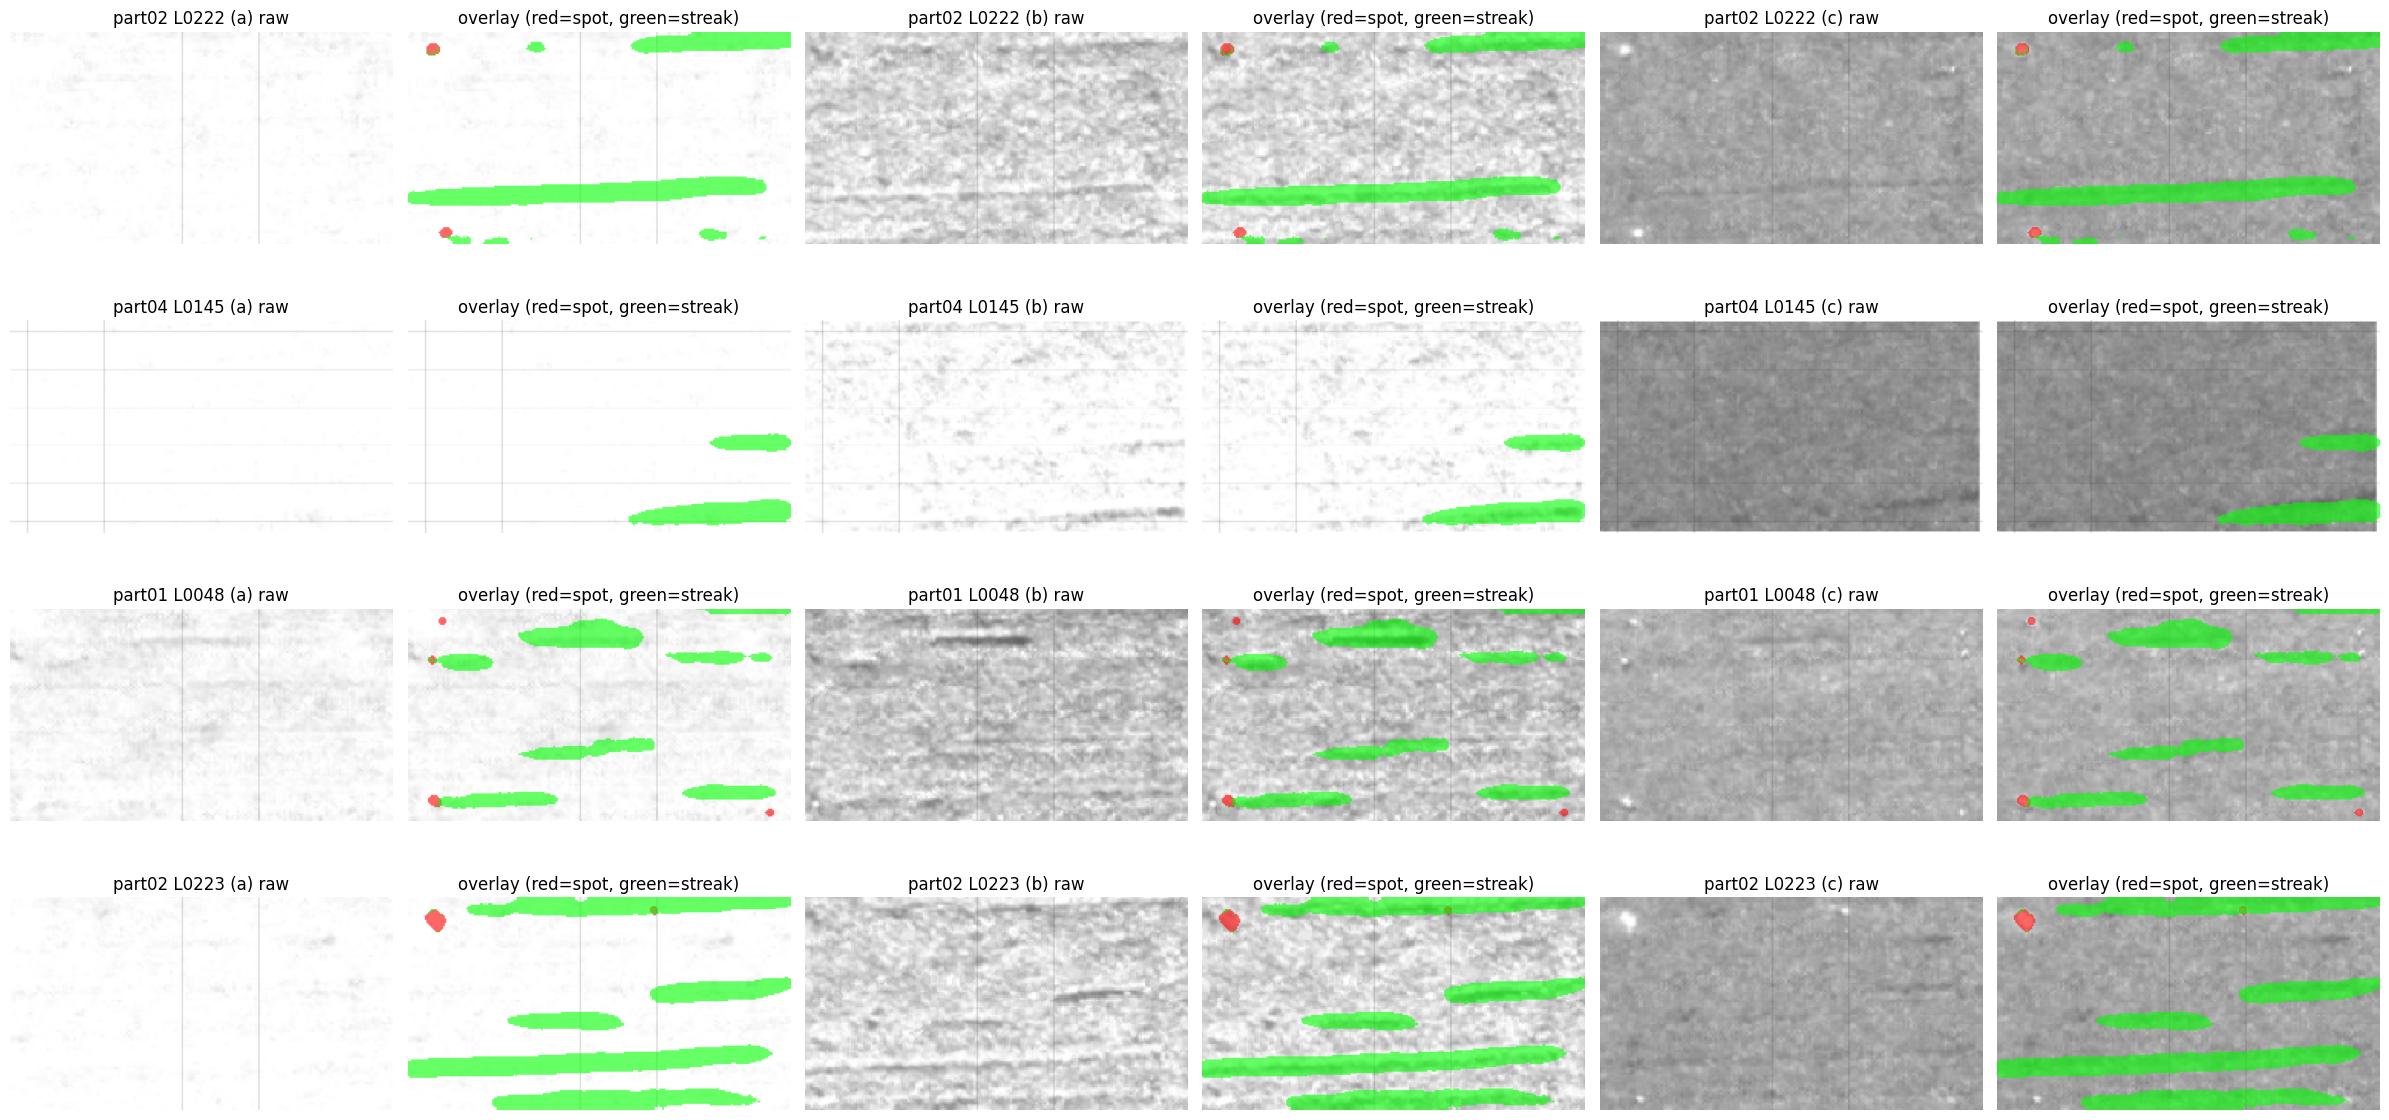

In [10]:
import pickle, numpy as np, matplotlib.pyplot as plt, random

def overlay_masks(img_uint8, spot_mask, streak_mask, alpha=0.6):
    img = img_uint8.astype(np.float32) / 255.0
    spot = spot_mask.astype(bool); streak = streak_mask.astype(bool)
    over = img.copy()
    over[spot]   = (1-alpha)*over[spot]   + alpha*np.array([1,0,0], dtype=np.float32)  # red
    over[streak] = (1-alpha)*over[streak] + alpha*np.array([0,1,0], dtype=np.float32)  # green
    return np.clip(over, 0, 1)

def show_random_layers_raw_and_overlay(pkl_path="NIST_Task1.pkl", n_layers=3, seed=10, lightings=('a','b','c'), alpha=0.6):
    d = pickle.load(open(pkl_path, "rb"))
    layers = [(part, lyr) for part in sorted(d.keys())
                        for lyr in d[part]
                        if isinstance(lyr.get("spot_label"), np.ndarray)
                        and isinstance(lyr.get("streak_label"), np.ndarray)]
    assert layers, "No predicted masks found"
    random.seed(seed)
    samp = random.sample(layers, k=min(n_layers, len(layers)))

    cols = len(lightings) * 2
    fig, axs = plt.subplots(len(samp), cols, figsize=(4*cols, 3*len(samp)))
    if len(samp) == 1:
        axs = np.expand_dims(axs, 0)

    for r, (part, lyr) in enumerate(samp):
        lid = lyr["layer_id"]; imgs = lyr["images"]
        spot = lyr["spot_label"]; streak = lyr["streak_label"]
        c = 0
        for lit in lightings:
            base = imgs[f"A{lid}{lit}"]
            axs[r, c].imshow(base); axs[r, c].set_title(f"{part} L{lid} ({lit}) raw"); axs[r, c].axis("off"); c += 1
            axs[r, c].imshow(overlay_masks(base, spot, streak, alpha=alpha))
            axs[r, c].set_title("overlay (red=spot, green=streak)"); axs[r, c].axis("off"); c += 1

    plt.tight_layout(); plt.show()

# Visualize 4 random test predictions
show_random_layers_raw_and_overlay("NIST_Task1.pkl", n_layers=4, seed=7, lightings=('a','b','c'), alpha=0.6)


In [11]:
# After training completes, copy to your Drive
import shutil

# You already have the model saved locally in Colab as "best_unet48_optimized.pt"
# Copy it to your Google Drive
shutil.copy("best_unet48_optimized.pt", "/content/drive/MyDrive/Hackathon_Challenge2/best_unet48_optimized.pt")
print("Model saved to Google Drive!")

Model saved to Google Drive!
